In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.optim import Adam

from GlaucomaDataset import GlaucomaDataset
from unet import UNet

### Read in and load Origa data

In [2]:
origa_path = os.path.join("..", "data", "ORIGA")
images_path = os.path.join(origa_path, "Images_Square")
masks_path = os.path.join(origa_path, "Masks_Square")

img_filenames = sorted(os.listdir(images_path))
mask_filenames = sorted(os.listdir(masks_path))

In [3]:
# Split into train, validation, and test sets (70, 15, 15)
train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(
    img_filenames, mask_filenames, test_size=0.3, random_state=42)

val_imgs, test_imgs, val_masks, test_masks = train_test_split(
    temp_imgs, temp_masks, test_size=0.5, random_state=42)

In [4]:
# Load data
batch_size = 8
n_workers = 4

train_set = GlaucomaDataset(images_path, masks_path, train_imgs, train_masks)
val_set = GlaucomaDataset(images_path, masks_path, val_imgs, val_masks)
test_set = GlaucomaDataset(images_path, masks_path, test_imgs, test_masks)

train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=n_workers, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=n_workers, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=n_workers, shuffle=True)

### Define metrics

In [5]:
def dice_coefficient(targets, preds, smooth=1e-6):
    # preds = (preds > 0.5).float 
    intersection = torch.sum(preds * targets, dim=(2,3))
    # want close to 1 (identical)
    dice = (2. * intersection + smooth) / (torch.sum(preds, dim=(2,3)) + torch.sum(targets, dim=(2,3)) + smooth)
    return dice.mean()

### Train and test loop

In [6]:
def trainloop(dataloader, model, device, loss_func, optimizer):
    num_batches = len(dataloader)
    train_loss, dice = 0., 0. 
    
    for image, image_name, mask, mask_name in dataloader:
        image, mask = image.to(device), mask.to(device)
        
        optimizer.zero_grad()
        pred = model(image)
        loss = loss_func(pred, mask)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        dice += dice_coefficient(pred, mask).item()
    train_loss /= num_batches
    dice /= num_batches
        
    return train_loss, dice

def testloop(dataloader, model, device, loss_func):
    num_batches = len(dataloader)
    test_loss, dice = 0. , 0.
    
    with torch.no_grad():
        for image, image_name, mask, mask_name in dataloader:
            image, mask = image.to(device), mask.to(device)
            pred = model(image)
            test_loss += loss_func(pred, mask).item()
            dice += dice_coefficient(pred, mask).item()
    test_loss /= num_batches
    dice /= num_batches
    
    return test_loss, dice

### Initialize and train RGB model

In [10]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3).to(device)

lr = 1e-4
loss_func = torch.nn.BCELoss(reduction='mean')
optimizer = Adam(model.parameters(), lr=lr)

In [14]:
# Training and validation
epochs = 60

for epoch in range(epochs):
    
    model.train()
    train_loss, dice = trainloop(train_loader, model, device, loss_func, optimizer)
    print(f"---Epoch {epoch+1}/{epochs}:---")
    print(f"Train Loss: {train_loss:.4f}   Train Dice: {dice:.4f}")
    
    model.eval()
    test_loss, dice = testloop(val_loader, model, device, loss_func)
    print(f"Test Error: \n Avg Loss: {test_loss:>8f}  Test Dice: {dice:.4f} \n")

---Epoch 1/60:---
Train Loss: 0.0042   Train Dice: 0.8440
Test Error: 
 Avg Loss: 0.004756  Test Dice: 0.8365 

---Epoch 2/60:---
Train Loss: 0.0042   Train Dice: 0.8380
Test Error: 
 Avg Loss: 0.004478  Test Dice: 0.8437 

---Epoch 3/60:---
Train Loss: 0.0041   Train Dice: 0.8427
Test Error: 
 Avg Loss: 0.004502  Test Dice: 0.8334 

---Epoch 4/60:---
Train Loss: 0.0040   Train Dice: 0.8470
Test Error: 
 Avg Loss: 0.004356  Test Dice: 0.8377 

---Epoch 5/60:---
Train Loss: 0.0039   Train Dice: 0.8493
Test Error: 
 Avg Loss: 0.004335  Test Dice: 0.8501 

---Epoch 6/60:---
Train Loss: 0.0039   Train Dice: 0.8505
Test Error: 
 Avg Loss: 0.004197  Test Dice: 0.8363 

---Epoch 7/60:---
Train Loss: 0.0039   Train Dice: 0.8478
Test Error: 
 Avg Loss: 0.004550  Test Dice: 0.8380 

---Epoch 8/60:---
Train Loss: 0.0038   Train Dice: 0.8511
Test Error: 
 Avg Loss: 0.004258  Test Dice: 0.8519 

---Epoch 9/60:---
Train Loss: 0.0043   Train Dice: 0.8406
Test Error: 
 Avg Loss: 0.004913  Test Dice: 0

In [15]:
# Save model
torch.save(model.state_dict(), 'model_state_dict.pth')

### Model 2 Test Predictions

In [7]:
# Load in model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3).to(device)
path = os.path.join(os.getcwd(), "model_state_dict.pth")
loss_func = torch.nn.BCELoss(reduction='mean')

if device.type == 'cuda':
    model.load_state_dict(torch.load(path, weights_only=True))
else:
    model.load_state_dict(torch.load(path, weights_only=True, map_location=torch.device('cpu')))

In [8]:
# Test loop
test_loss, dice = testloop(test_loader, model, device, loss_func)
print(f"Test Loss: {test_loss}")
print(f"Test Dice Coefficient: {dice}")

Test Loss: 0.004554652214909975
Test Dice Coefficient: 0.874137662924253


In [7]:
def predict_masks(test_iter, model, loss_func, plot=True):
    
    image_batch, image_filename, mask_batch, mask_filename = next(test_iter)
    image = image_batch[0]
    mask = mask_batch[0]
    image = image.unsqueeze(0).to(device) # add batch dim
    mask = mask.to(device)

    with torch.no_grad():
        pred = model(image)

    od_loss = loss_func(pred[0][0], mask[0])
    oc_loss = loss_func(pred[0][1], mask[1])

    print(f"Optic Disc Loss: {od_loss}")
    print(f"Optic Cup Loss: {oc_loss}")

    pred = pred.squeeze(0).cpu().numpy()
    mask = mask.cpu().numpy()
    pred_od = pred[0]
    pred_oc = pred[1]
    pred_od = (pred_od > 0.5).astype(int)
    pred_oc = (pred_oc > 0.5).astype(int)

    image = image.squeeze().cpu().numpy().transpose(1,2,0)
    
    # Plot overlay of masks
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        color_mask = np.zeros_like(image)
        color_mask[mask[0] == 1] = 255
        od_mask = color_mask

        color_mask = np.zeros_like(image)
        color_mask[mask[1] == 1] = 255
        oc_mask = color_mask

        color_mask = np.zeros_like(image)
        color_mask[pred_od == 1] = 255
        od_mask_pred = color_mask

        color_mask = np.zeros_like(image)
        color_mask[pred_oc == 1] = 255
        oc_mask_pred = color_mask

        ax[0].imshow(image)
        ax[0].imshow(od_mask, alpha=0.3)
        ax[0].imshow(oc_mask, alpha=0.15)
        ax[0].set_title("Ground Truth Masks")

        ax[1].imshow(image)
        ax[1].imshow(od_mask_pred, alpha=0.3)
        ax[1].imshow(oc_mask_pred, alpha=0.15)
        ax[1].set_title("Predicted Masks")
    
    return mask, pred_od, pred_oc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Optic Disc Loss: 0.001324015436694026
Optic Cup Loss: 0.0020240501035004854


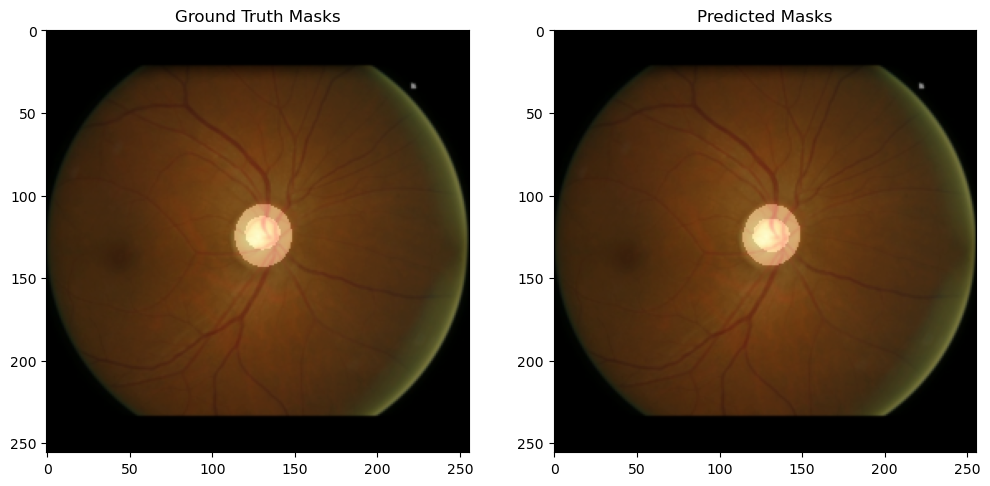

In [10]:
test_iter = iter(test_loader)
mask, pred_od, pred_oc = predict_masks(test_iter, model, loss_func)

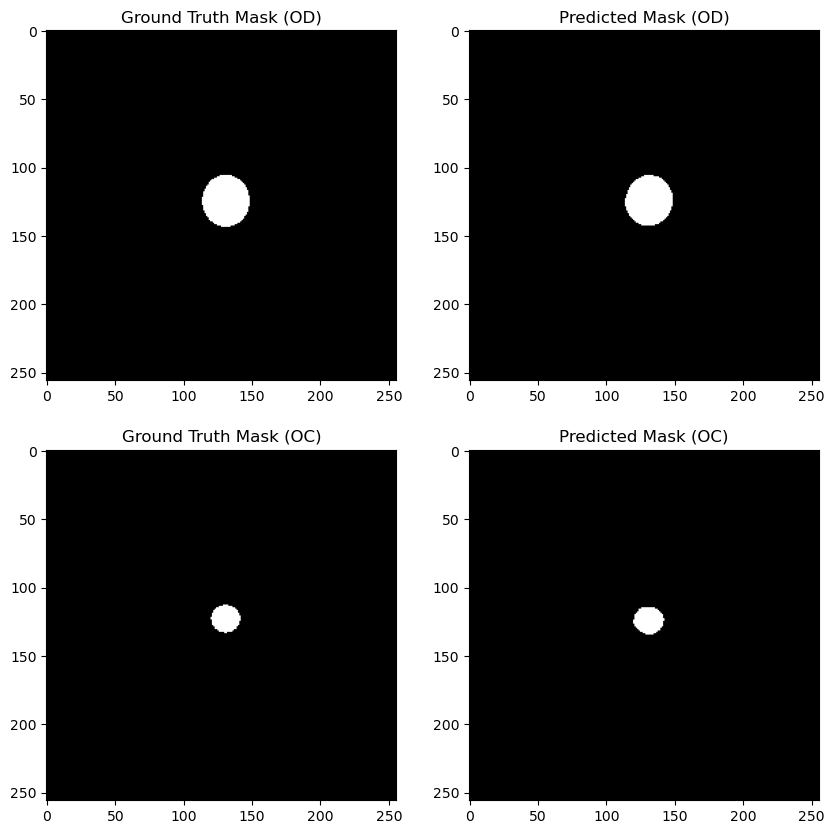

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))

ax[0,0].imshow(mask[0], cmap='gray')
ax[0,0].set_title("Ground Truth Mask (OD)")

ax[0,1].imshow(pred_od, cmap='gray')
ax[0,1].set_title("Predicted Mask (OD)")

ax[1,0].imshow(mask[1], cmap='gray')
ax[1,0].set_title("Ground Truth Mask (OC)")

ax[1,1].imshow(pred_oc, cmap='gray')
ax[1,1].set_title("Predicted Mask (OC)")

plt.show()

## Hybrid BCE and Dice Loss

In [8]:
from torch import nn

class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5, smooth=1e-5):
        super(BCEDiceLoss, self).__init__()
        self.bce_loss = torch.nn.BCELoss(reduction='mean')
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.smooth = smooth
        
    def dice(self, pred, target):
        """Computes dice loss"""
        # Sums on channel, height, width dimensions 
        while pred.dim() < 4:
            pred = pred.unsqueeze(0)
        while target.dim() < 4: 
            target = target.unsqueeze(0)
            
        intersection = (pred * target).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()
    
    def forward(self, preds, target):
        """Computes hybrid BCE and dice loss"""
        bce = self.bce_loss(preds, target)
        dice = self.dice(preds, target)
        loss = bce * self.bce_weight + dice * self.dice_weight
        return loss

### Initialize and train hybrid loss model

In [14]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3).to(device)

lr = 1e-4
loss_func = BCEDiceLoss(bce_weight=0.5, dice_weight=0.5)
optimizer = Adam(model.parameters(), lr=lr)

In [16]:
# Training and validation
epochs = 60

for epoch in range(epochs):
    
    model.train()
    train_loss, dice = trainloop(train_loader, model, device, loss_func, optimizer)
    print(f"---Epoch {epoch+1}/{epochs}:---")
    print(f"Train Loss: {train_loss:.4f}   Train Dice: {dice:.4f}")
    
    model.eval()
    test_loss, dice = testloop(val_loader, model, device, loss_func)
    print(f"Test Error: \n Avg Loss: {test_loss:>8f}  Test Dice: {dice:.4f} \n")

---Epoch 1/60:---
Train Loss: 0.6404   Train Dice: 0.0085
Test Error: 
 Avg Loss: 0.521825  Test Dice: 0.0157 

---Epoch 2/60:---
Train Loss: 0.3514   Train Dice: 0.3270
Test Error: 
 Avg Loss: 0.271664  Test Dice: 0.4804 

---Epoch 3/60:---
Train Loss: 0.2313   Train Dice: 0.5973
Test Error: 
 Avg Loss: 0.156627  Test Dice: 0.7454 

---Epoch 4/60:---
Train Loss: 0.1561   Train Dice: 0.7359
Test Error: 
 Avg Loss: 0.137270  Test Dice: 0.7715 

---Epoch 5/60:---
Train Loss: 0.1209   Train Dice: 0.7918
Test Error: 
 Avg Loss: 0.113572  Test Dice: 0.8084 

---Epoch 6/60:---
Train Loss: 0.1137   Train Dice: 0.8052
Test Error: 
 Avg Loss: 0.147649  Test Dice: 0.7453 

---Epoch 7/60:---
Train Loss: 0.1043   Train Dice: 0.8156
Test Error: 
 Avg Loss: 0.101498  Test Dice: 0.8239 

---Epoch 8/60:---
Train Loss: 0.0939   Train Dice: 0.8318
Test Error: 
 Avg Loss: 0.095797  Test Dice: 0.8369 

---Epoch 9/60:---
Train Loss: 0.0898   Train Dice: 0.8385
Test Error: 
 Avg Loss: 0.092785  Test Dice: 0

In [17]:
# Save trained model for future reference
torch.save(model.state_dict(), 'model_hybrid_state_dict.pth')

### Model 2 test predictions

In [13]:
# Load in model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3).to(device)
path = os.path.join(os.getcwd(), "model_hybrid_state_dict.pth")
loss_func = BCEDiceLoss(bce_weight=0.5, dice_weight=0.5)

if device.type == 'cuda':
    model.load_state_dict(torch.load(path, weights_only=True))
else:
    model.load_state_dict(torch.load(path, weights_only=True, map_location=torch.device('cpu')))

In [14]:
# Test loop
test_loss, dice = testloop(test_loader, model, device, loss_func)
print(f"Test Loss: {test_loss}")
print(f"Test Dice Coefficient: {dice}")

Test Loss: 0.05639321013138844
Test Dice Coefficient: 0.8956939807304969


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Optic Disc Loss: 0.02331443689763546
Optic Cup Loss: 0.03980641067028046


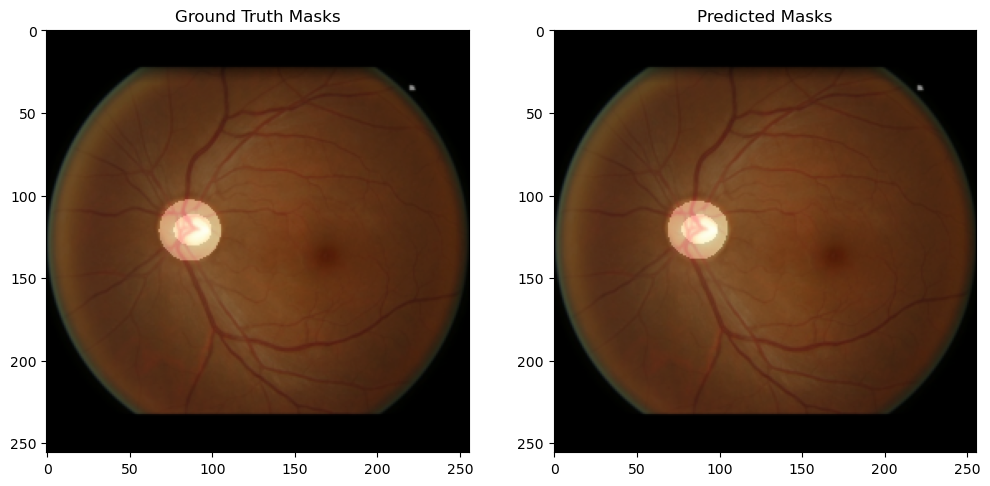

In [15]:
# Visualize predicted masks
test_iter = iter(test_loader)
mask, pred_od, pred_oc = predict_masks(test_iter, model, loss_func)

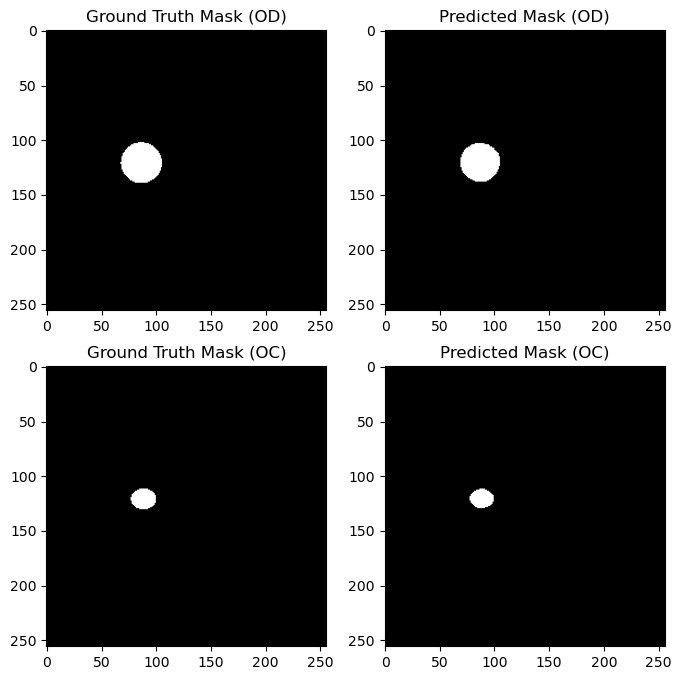

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))

ax[0,0].imshow(mask[0], cmap='gray')
ax[0,0].set_title("Ground Truth Mask (OD)")

ax[0,1].imshow(pred_od, cmap='gray')
ax[0,1].set_title("Predicted Mask (OD)")

ax[1,0].imshow(mask[1], cmap='gray')
ax[1,0].set_title("Ground Truth Mask (OC)")

ax[1,1].imshow(pred_oc, cmap='gray')
ax[1,1].set_title("Predicted Mask (OC)")

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Optic Disc Loss: 0.04225876182317734
Optic Cup Loss: 0.24312624335289001


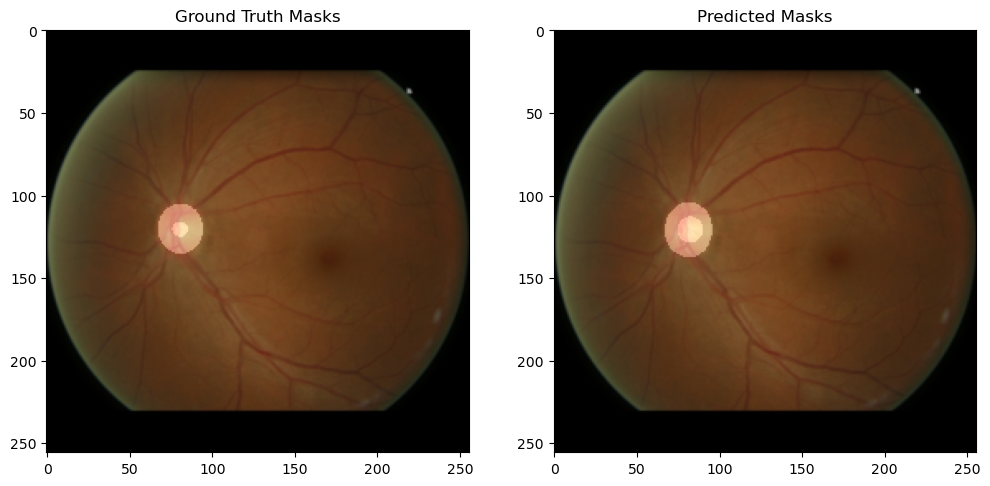

In [17]:
mask, pred_od, pred_oc = predict_masks(test_iter, model, loss_func)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Optic Disc Loss: 0.013666819781064987
Optic Cup Loss: 0.032026976346969604


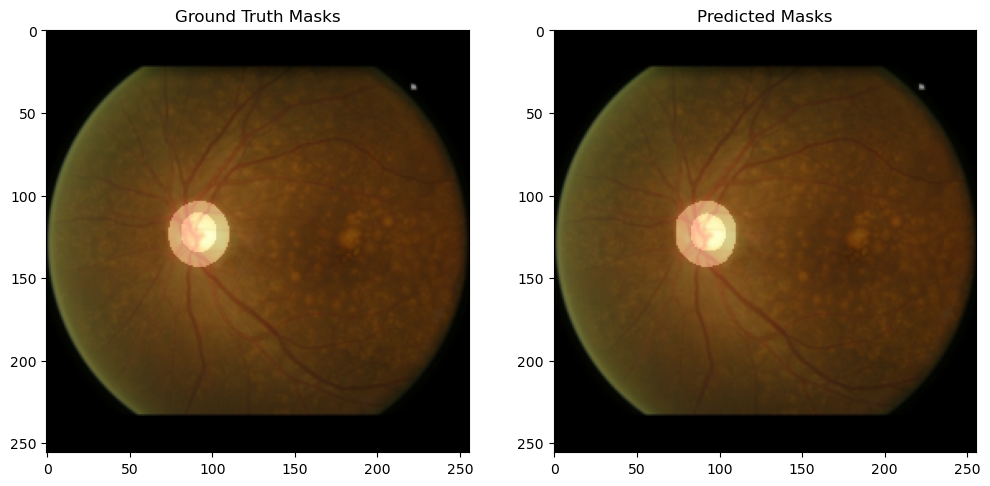

In [18]:
mask, pred_od, pred_oc = predict_masks(test_iter, model, loss_func)

## Optic Cup to Disc Ratio

In [9]:
def cup_to_disc(cup_mask, disc_mask):
    """
    Input: Numpy array masks of 1s and 0s for the optic cup and optic disc.
    Output: Float representing the cup-to-disc ratio.
    """
    oc = np.sum(cup_mask)
    od = np.sum(disc_mask)
    
    return oc / od

In [20]:
mask, pred_od, pred_oc = predict_masks(test_iter, model, loss_func, plot=False)
print("\nGround Truth CDR: ", cup_to_disc(mask[1], mask[0]))
print("Predicted CDR: ", cup_to_disc(pred_oc, pred_od))

Optic Disc Loss: 0.020499883219599724
Optic Cup Loss: 0.04147958382964134

Ground Truth CDR:  0.2900232
Predicted CDR:  0.3208791208791209


In [21]:
mask, pred_od, pred_oc = predict_masks(test_iter, model, loss_func, plot=False)
print("\nGround Truth CDR: ", cup_to_disc(mask[1], mask[0]))
print("Predicted CDR: ", cup_to_disc(pred_oc, pred_od))

Optic Disc Loss: 0.04427618533372879
Optic Cup Loss: 0.05857982486486435

Ground Truth CDR:  0.3683258
Predicted CDR:  0.31191088260497


## Test models on clinic images

In [10]:
def predict(image, model, device, plot=True):
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(image)

    pred = pred.squeeze(0).cpu().numpy()
    pred_od = pred[0]
    pred_oc = pred[1]

    pred_od = (pred_od > 0.5).astype(int)
    pred_oc = (pred_oc > 0.5).astype(int)

    if plot:
        image = image.squeeze().cpu().numpy().transpose(1,2,0)
        fig, ax = plt.subplots(1, 3, figsize=(6, 2))
        ax[0].imshow(image)
        ax[0].set_title("Input Image")
        ax[1].imshow(pred_od, cmap='gray')  # Optic Disc
        ax[1].set_title("Predicted OD")
        ax[2].imshow(pred_oc, cmap='gray')  # Optic Cup
        ax[2].set_title("Predicted OC")
        plt.show()

    return pred_od, pred_oc

In [11]:
# Read in image files 
clinic_path = os.path.join("..", "data", "Clinic")
subject1_cd1_path = os.path.join(clinic_path, "Subject_1_CD_1")
subject1_cd2_path = os.path.join(clinic_path, "Subject_1_CD_2")

cd1_filenames = sorted(os.listdir(subject1_cd1_path))
cd2_filenames = sorted(os.listdir(subject1_cd2_path))

In [24]:
# Pre-processing 
images_cd1 = []
for img in cd1_filenames:
    img_name = os.path.join(subject1_cd1_path, img)
    img = np.array(Image.open(img_name).convert('RGB')) 
    img = transforms.functional.to_tensor(img)
    img = transforms.functional.resize(img, size=(256,256), interpolation=Image.BILINEAR)
    images_cd1.append(img)

images_cd2 = []
for img in cd2_filenames:
    img_name = os.path.join(subject1_cd2_path, img)
    img = np.array(Image.open(img_name).convert('RGB'))
    img = transforms.functional.to_tensor(img)
    img = transforms.functional.resize(img, size=(256,256), interpolation=Image.BILINEAR)
    images_cd2.append(img)

### Model 1 (Normal RGB)

In [25]:
# Load in model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3).to(device)
path = os.path.join(os.getcwd(), "model_state_dict.pth")

if device.type == 'cuda':
    model.load_state_dict(torch.load(path, weights_only=True))
else:
    model.load_state_dict(torch.load(path, weights_only=True, map_location=torch.device('cpu')))

Top 3 predictions from video 1:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


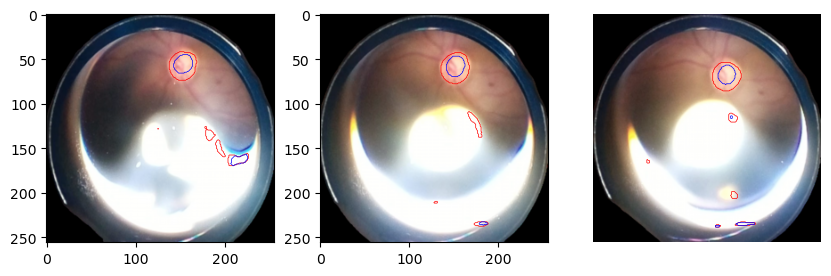

In [26]:
pred_od1, pred_oc1 = predict(images_cd1[5], model, device, plot=False)
img1 = images_cd1[5].squeeze().cpu().numpy().transpose(1,2,0)

pred_od2, pred_oc2 = predict(images_cd1[8], model, device, plot=False)
img2 = images_cd1[8].squeeze().cpu().numpy().transpose(1,2,0)

pred_od3, pred_oc3 = predict(images_cd1[15], model, device, plot=False)
img3 = images_cd1[15].squeeze().cpu().numpy().transpose(1,2,0)

fig, ax = plt.subplots(1, 3, figsize=(10,10))
ax[0].imshow(img1)
ax[0].contour(pred_od1, levels=[0.5], colors="red", linewidths=0.5)
ax[0].contour(pred_oc1, levels=[0.5], colors="blue", linewidths=0.5)

ax[1].imshow(img2)
ax[1].contour(pred_od2, levels=[0.5], colors="red", linewidths=0.5)
ax[1].contour(pred_oc2, levels=[0.5], colors="blue", linewidths=0.5)

ax[2].imshow(img3)
ax[2].contour(pred_od3, levels=[0.5], colors="red", linewidths=0.5)
ax[2].contour(pred_oc3, levels=[0.5], colors="blue", linewidths=0.5)

plt.axis("off")
plt.show()

Top 3 predictions from video 2:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


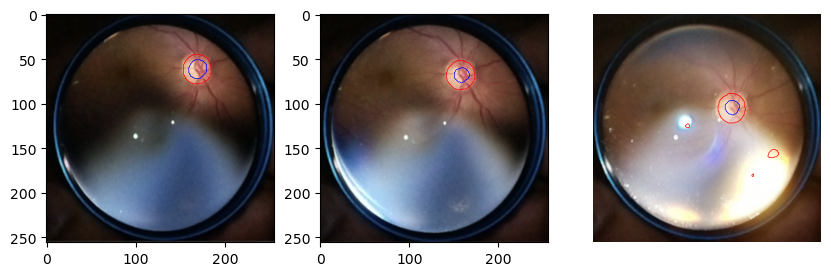

In [27]:
pred_od1, pred_oc1 = predict(images_cd2[2], model, device, plot=False)
img1 = images_cd2[2].squeeze().cpu().numpy().transpose(1,2,0)

pred_od2, pred_oc2 = predict(images_cd2[3], model, device, plot=False)
img2 = images_cd2[3].squeeze().cpu().numpy().transpose(1,2,0)

pred_od3, pred_oc3 = predict(images_cd2[5], model, device, plot=False)
img3 = images_cd2[5].squeeze().cpu().numpy().transpose(1,2,0)

fig, ax = plt.subplots(1, 3, figsize=(10,10))
ax[0].imshow(img1)
ax[0].contour(pred_od1, levels=[0.5], colors="red", linewidths=0.5)
ax[0].contour(pred_oc1, levels=[0.5], colors="blue", linewidths=0.5)

ax[1].imshow(img2)
ax[1].contour(pred_od2, levels=[0.5], colors="red", linewidths=0.5)
ax[1].contour(pred_oc2, levels=[0.5], colors="blue", linewidths=0.5)

ax[2].imshow(img3)
ax[2].contour(pred_od3, levels=[0.5], colors="red", linewidths=0.5)
ax[2].contour(pred_oc3, levels=[0.5], colors="blue", linewidths=0.5)

plt.axis("off")
plt.show()

### Model 2: Hybrid Loss

In [28]:
# Load in model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3).to(device)
path = os.path.join(os.getcwd(), "model_hybrid_state_dict.pth")

if device.type == 'cuda':
    model.load_state_dict(torch.load(path, weights_only=True))
else:
    model.load_state_dict(torch.load(path, weights_only=True, map_location=torch.device('cpu')))

Top three predictions from video 1:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


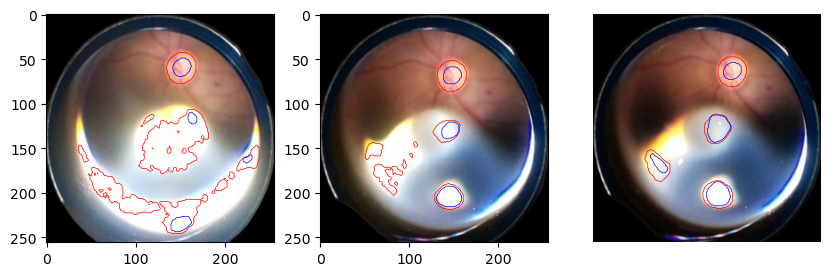

In [29]:
pred_od1, pred_oc1 = predict(images_cd1[8], model, device, plot=False)
img1 = images_cd1[8].squeeze().cpu().numpy().transpose(1,2,0)

pred_od2, pred_oc2 = predict(images_cd1[17], model, device, plot=False)
img2 = images_cd1[17].squeeze().cpu().numpy().transpose(1,2,0)

pred_od3, pred_oc3 = predict(images_cd1[23], model, device, plot=False)
img3 = images_cd1[23].squeeze().cpu().numpy().transpose(1,2,0)

fig, ax = plt.subplots(1, 3, figsize=(10,10))
ax[0].imshow(img1)
ax[0].contour(pred_od1, levels=[0.5], colors="red", linewidths=0.5)
ax[0].contour(pred_oc1, levels=[0.5], colors="blue", linewidths=0.5)

ax[1].imshow(img2)
ax[1].contour(pred_od2, levels=[0.5], colors="red", linewidths=0.5)
ax[1].contour(pred_oc2, levels=[0.5], colors="blue", linewidths=0.5)

ax[2].imshow(img3)
ax[2].contour(pred_od3, levels=[0.5], colors="red", linewidths=0.5)
ax[2].contour(pred_oc3, levels=[0.5], colors="blue", linewidths=0.5)

plt.axis("off")
plt.show()

Top 3 predictions on video 2:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


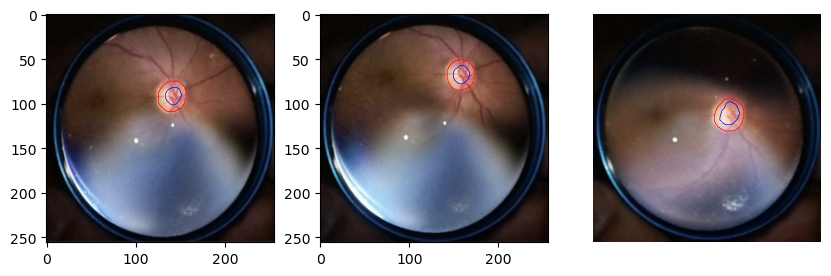

In [30]:
pred_od1, pred_oc1 = predict(images_cd2[1], model, device, plot=False)
img1 = images_cd2[1].squeeze().cpu().numpy().transpose(1,2,0)

pred_od2, pred_oc2 = predict(images_cd2[3], model, device, plot=False)
img2 = images_cd2[3].squeeze().cpu().numpy().transpose(1,2,0)

pred_od3, pred_oc3 = predict(images_cd2[6], model, device, plot=False)
img3 = images_cd2[6].squeeze().cpu().numpy().transpose(1,2,0)

fig, ax = plt.subplots(1, 3, figsize=(10,10))
ax[0].imshow(img1)
ax[0].contour(pred_od1, levels=[0.5], colors="red", linewidths=0.5)
ax[0].contour(pred_oc1, levels=[0.5], colors="blue", linewidths=0.5)

ax[1].imshow(img2)
ax[1].contour(pred_od2, levels=[0.5], colors="red", linewidths=0.5)
ax[1].contour(pred_oc2, levels=[0.5], colors="blue", linewidths=0.5)

ax[2].imshow(img3)
ax[2].contour(pred_od3, levels=[0.5], colors="red", linewidths=0.5)
ax[2].contour(pred_oc3, levels=[0.5], colors="blue", linewidths=0.5)

plt.axis("off")
plt.show()

## CDR for Clinic Images

Step 1: filter out predicted masks that aren't disc/cup

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


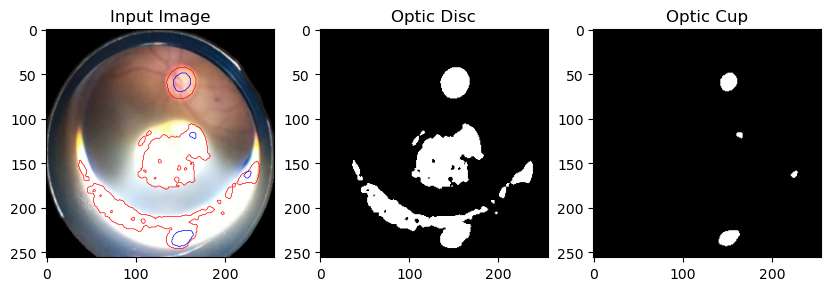

In [31]:
# Image one with hybrid model predictions
pred_od, pred_oc = predict(images_cd1[8], model, device, plot=False)
img = images_cd1[8].squeeze().cpu().numpy().transpose(1,2,0)

fig, ax = plt.subplots(1, 3, figsize=(10,10))
ax[0].imshow(img)
ax[0].contour(pred_od, levels=[0.5], colors="red", linewidths=0.5)
ax[0].contour(pred_oc, levels=[0.5], colors="blue", linewidths=0.5)
ax[0].set_title("Input Image")

ax[1].imshow(pred_od, cmap='gray')
ax[1].set_title("Optic Disc")

ax[2].imshow(pred_oc, cmap='gray')
ax[2].set_title("Optic Cup")

plt.show()

To get cleaner masks: save disc and cup masks as pngs, use bounding box widget to specify ROI, and convert all pixels outside of bounds to zero.

In [32]:
# Read in bounding box data
bbox_df = pd.read_csv("bounding_boxes.csv")

# Optic cup bounding box
bbox_mask = np.zeros([1, 256, 256])
x_min, y_min, x_max, y_max = bbox_df[["x1", "y1", "x2", "y2"]].iloc[0].values
bbox_mask[0][y_min:y_max, x_min:x_max] = 1
oc_box = bbox_mask[0]

# Optic disc bounding box
bbox_mask = np.zeros([1, 256, 256])
x_min, y_min, x_max, y_max = bbox_df[["x1", "y1", "x2", "y2"]].iloc[1].values
bbox_mask[0][y_min:y_max, x_min:x_max] = 1
od_box = bbox_mask[0]

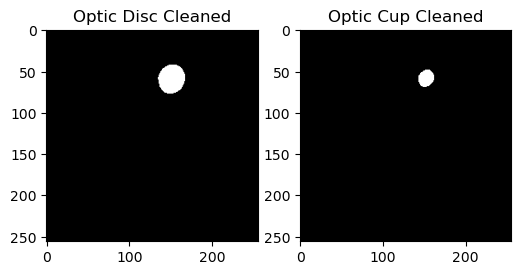

In [33]:
# Clean predicted masks using bounding box
oc_mask_clean = pred_oc * oc_box
od_mask_clean = pred_od * od_box

fig, ax = plt.subplots(1,2, figsize=(6,6))
ax[0].imshow(od_mask_clean, cmap='gray')
ax[0].set_title("Optic Disc Cleaned")

ax[1].imshow(oc_mask_clean, cmap='gray')
ax[1].set_title("Optic Cup Cleaned")
plt.show()

Cup to Disc Ratio:

In [34]:
# Get CDR with cleaned masks
print("CDR: ", cup_to_disc(oc_mask_clean, od_mask_clean))

CDR:  0.34517203107658156


# REFUGE data

In [14]:
refuge_path = os.path.join("..", "data", "REFUGE2")
train_images_path = os.path.join(refuge_path, "train", "images")
train_masks_path = os.path.join(refuge_path, "train", "mask")

train_images = sorted(os.listdir(train_images_path))
train_masks = sorted(os.listdir(train_masks_path))

In [15]:
val_images_path = os.path.join(refuge_path, "val", "images")
val_masks_path = os.path.join(refuge_path, "val", "mask")

val_images = sorted(os.listdir(val_images_path))
val_masks = sorted(os.listdir(val_masks_path))

In [16]:
test_images_path = os.path.join(refuge_path, "test", "images")
test_masks_path = os.path.join(refuge_path, "test", "mask")

test_images = sorted(os.listdir(test_images_path))
test_masks = sorted(os.listdir(test_masks_path))

In [18]:
# Load test data (400 images/masks)
batch_size = 8
n_workers = 4

train_set = GlaucomaDataset(train_images_path, train_masks_path, train_images, train_masks, refuge=True)
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=n_workers, shuffle=True)

val_set = GlaucomaDataset(val_images_path, val_masks_path, val_images, val_masks, refuge=True)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=n_workers, shuffle=True)

test_set = GlaucomaDataset(test_images_path, test_masks_path, test_images, test_masks, refuge=True)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=n_workers, shuffle=True)

## Initialize and train model with Refuge data

In [19]:
# Load in hybrid loss model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3).to(device)
path = os.path.join(os.getcwd(), "model_hybrid_state_dict.pth")

if device.type == 'cuda':
    model.load_state_dict(torch.load(path, weights_only=True))
else:
    model.load_state_dict(torch.load(path, weights_only=True, map_location=torch.device('cpu')))

In [20]:
# Parameters
lr = 1e-4
loss_func = BCEDiceLoss(bce_weight=0.5, dice_weight=0.5)
optimizer = Adam(model.parameters(), lr=lr)

In [21]:
# Training and validation loop
epochs = 60

for epoch in range(epochs):
    
    model.train()
    train_loss, dice = trainloop(train_loader, model, device, loss_func, optimizer)
    print(f"---Epoch {epoch+1}/{epochs}:---")
    print(f"Train Loss: {train_loss:.4f}   Train Dice: {dice:.4f}")
    
    model.eval()
    test_loss, dice = testloop(val_loader, model, device, loss_func)
    print(f"Test Error: \n Avg Loss: {test_loss:>8f}  Test Dice: {dice:.4f} \n")

---Epoch 1/60:---
Train Loss: 0.1297   Train Dice: 0.7982
Test Error: 
 Avg Loss: 0.121168  Test Dice: 0.7695 

---Epoch 2/60:---
Train Loss: 0.0784   Train Dice: 0.8536
Test Error: 
 Avg Loss: 0.110163  Test Dice: 0.7910 

---Epoch 3/60:---
Train Loss: 0.0720   Train Dice: 0.8657
Test Error: 
 Avg Loss: 0.102894  Test Dice: 0.8042 

---Epoch 4/60:---
Train Loss: 0.0703   Train Dice: 0.8685
Test Error: 
 Avg Loss: 0.102059  Test Dice: 0.8089 

---Epoch 5/60:---
Train Loss: 0.0683   Train Dice: 0.8722
Test Error: 
 Avg Loss: 0.120556  Test Dice: 0.7747 

---Epoch 6/60:---
Train Loss: 0.0682   Train Dice: 0.8727
Test Error: 
 Avg Loss: 0.106544  Test Dice: 0.7996 

---Epoch 7/60:---
Train Loss: 0.0656   Train Dice: 0.8770
Test Error: 
 Avg Loss: 0.120238  Test Dice: 0.7753 

---Epoch 8/60:---
Train Loss: 0.0669   Train Dice: 0.8750
Test Error: 
 Avg Loss: 0.102109  Test Dice: 0.8082 

---Epoch 9/60:---
Train Loss: 0.0660   Train Dice: 0.8770
Test Error: 
 Avg Loss: 0.142423  Test Dice: 0

In [22]:
# Save new model weights 
torch.save(model.state_dict(), 'model_refuge_state_dict.pth')

## Test loop and predictions

In [23]:
# Test loop
test_loss, dice = testloop(test_loader, model, device, loss_func)
print(f"Test Loss: {test_loss}")
print(f"Test Dice Coefficient: {dice}")

Test Loss: 0.15236320227384567
Test Dice Coefficient: 0.724837611913681


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Optic Disc Loss: 0.15544144809246063
Optic Cup Loss: 0.18728743493556976


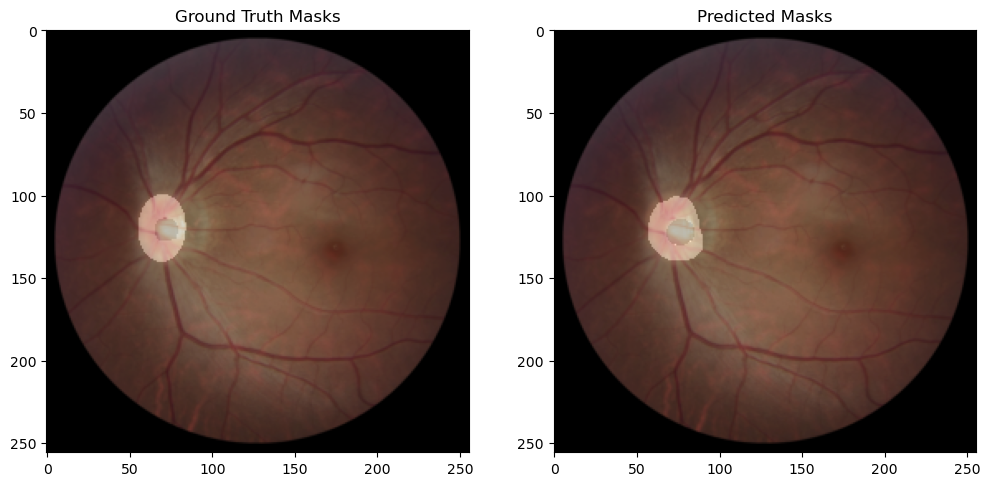

In [27]:
# Visualize some predictions 
test_iter = iter(test_loader)
mask, pred_od, pred_oc = predict_masks(test_iter, model, loss_func)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Optic Disc Loss: 0.2073597013950348
Optic Cup Loss: 0.264436811208725


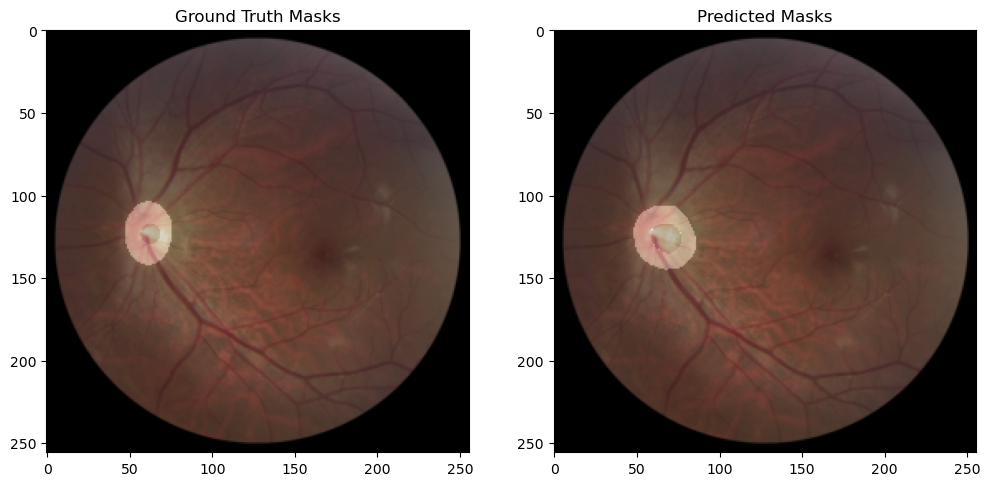

In [28]:
mask, pred_od, pred_oc = predict_masks(test_iter, model, loss_func)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Optic Disc Loss: 0.061614688485860825
Optic Cup Loss: 0.09410575777292252


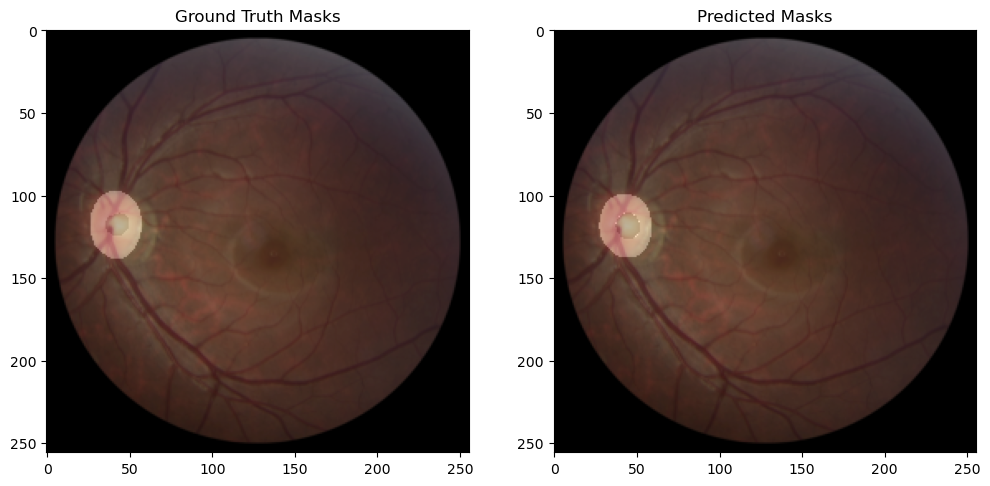

In [29]:
mask, pred_od, pred_oc = predict_masks(test_iter, model, loss_func)